# Setup

In [1]:
# === Import libraries ===
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from ssm import *
import pandas as pd
import os
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import re
npr.seed(0)

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
# ===== BEFORE EACH EXPERIMENT =====
# === Choose these variables ===
save_data = True
test_type = 'simulation1'       # Choose between the ones under, or write a new one.
want_another_test = False       # Only for test_type = 'test_model'. If you choose to perform a new noiseless simulation/test.

In [12]:
# === Set up of variables specific to the experiment ===
root_dir = os.getcwd()
directory_HMM = os.path.join(root_dir, 'HMM', 'HMM_visual_perception', test_type)
directory_plot = os.path.join(root_dir, 'plots', 'plots_visual_perception', test_type)
os.makedirs(directory_plot, exist_ok=True)  # Create the directories if they do not exist
os.makedirs(directory_HMM, exist_ok=True)

bias = True                             # by default
test_type_title = ''

int_var = 'prev_resp'                   # prev_resp (previous response) or previous (previous orientation) as internal variable/input
int_var_title = 'Previous Response'     # Previous Response or Previous Orientation as internal variable/input
ext_var = 'theta'                       # theta (renamed 'orientation') or contrast as external variable/input
ext_var_title = 'Orientation'           # Orientation or Contrast as external variable/input

# === without certain time delays ===
if test_type.startswith("without") and test_type.endswith("ms"):
    n_ms = int(re.search(r"without(\d+)ms", test_type).group(1))
    if n_ms != 0:
        test_type_title = ' - without<' + str(n_ms) + 'ms'
    else: test_type_title = ' - without0ms'

# === without bias ===
elif test_type == 'withoutbias':
    test_type_title = ' - without bias'
    bias = False

# === without participant 6 ===
elif test_type == 'without006':
    test_type_title = ' - without 006'

# === with participant 6 ===        # by default, participant 6 is included
elif test_type == 'with006':
    test_type_title = ''

# === testing model with a noiseless simulation ===
elif test_type == 'test_model':
    test_type_title = ' - test'

# ===== SIMULATIONS =====
if test_type.startswith("simulation"):
    int_var = 'previous'
    int_var_title = 'Previous Orientation'
    ext_var = 'stim*contrast'
    ext_var_title = 'Stim*Contrast'

    # === simulation1 ===                               
    if test_type == 'simulation1':
        test_type_title = ' - simulation1'   

    # === simulation1: all data as 1 participant/ID ===         
    elif test_type == 'simulation1-1part':
        test_type_title = ' - simulation1, 1 whole data'   

    # === simulation1: 2 blocks per participant/ID ===
    elif test_type == 'simulation1-2blocks':
        test_type_title = ' - simulation1, 2 blocks per ID'   

    # === simulation1: without bias ===
    elif test_type == 'simulation1-withoutbias':
        test_type_title = ' - simulation1, without bias'   
        bias = False

    # === simulation2 ===
    elif test_type == 'simulation2':
        test_type_title = ' - simulation2'   

    # === simulation2: all data as 1 participant/ID ===
    elif test_type == 'simulation2-1part':
        test_type_title = ' - simulation2, 1 whole data'   

    # === simulation2: without bias ===
    elif test_type == 'simulation2-withoutbias':
        test_type_title = ' - simulation2, without bias'   
        bias = False

    # === simulation3 ===
    elif test_type == 'simulation3':
        test_type_title = ' - simulation3'   
        bias = True

    # === simulation4 ===
    elif test_type == 'simulation4':
        test_type_title = ' - simulation4'   

    # === simulation5 ===
    elif test_type == 'simulation5':
        test_type_title = ' - simulation5'   

    # === simulation5: without bias ===
    elif test_type == 'simulation5-withoutbias':
        test_type_title = ' - simulation5, without bias'   
        bias = False

    # === simulation5: coefficients were manually adjusted (*20) ===
    elif test_type == 'simulation5-adj':
        test_type_title = ' - simulation5, adjusted'   

    # === simulation5: coefficients were normalized ===
    elif test_type == 'simulation5-norm':
        test_type_title = ' - simulation5, normalized'   

    # === simulation5: coefficients were normalized, without bias===
    elif test_type == 'simulation5-norm-withoutbias':
        test_type_title = ' - simulation5, normalized, without bias'   
        bias = False

    # === simulation5: coefficients were chosen regarding symmetry ===
    elif test_type == 'simulation5-sym':
        test_type_title = ' - simulation5, symmetrical around +-1'   



## Check that the model is working

In [13]:
# === Create and prepare a new noiseless simulation 'test_model' ===
if want_another_test == True and test_type == 'test_model':
    n = 9000 # Number of trials
    trials = np.arange(1, n +1)
    responses = np.zeros(n, dtype=int)
    stimulus = npr.choice([-1, 1], size=n)

    orientation_perc_external = 0.70    # Probability of simulated responses following orientation in external state
    prev_resp_perc_external = 1 - orientation_perc_external
    orientation_perc_internal = 0.10    # Probability of simulated responses following orientation in internal state
    prev_resp_perc_internal = 1 - orientation_perc_internal

    breakpoints = np.sort(npr.choice(range(1, n), size=19, replace=False))
    breakpoints = np.concatenate(([0], breakpoints, [n]))
    intervals = [trials[breakpoints[i]:breakpoints[i+1]] for i in range(len(breakpoints) - 1)]

    odd_length = 0
    even_length = 0

    for i, interval in enumerate(intervals):
        interval_length = len(interval)
        if (i+1)%2 == 0:                # i+1 even -> external state
            even_length += interval_length
            for j in range(len(interval)):
                idx = interval[j] - 1 
                if npr.rand() < orientation_perc_external:
                    responses[idx] = stimulus[idx]
                else:
                    if idx > 0:
                        responses[idx] = responses[idx - 1]
                    else:
                        responses[idx] = stimulus[idx]  
        else:                           # i+1 odd -> internal state
            odd_length += interval_length
            for j in range(len(interval)):
                idx = interval[j] - 1  
                if npr.rand() < orientation_perc_internal:
                    responses[idx] = stimulus[idx]
                else:
                    if idx > 0:
                        responses[idx] = responses[idx - 1]
                    else:
                        responses[idx] = stimulus[idx] 

    prev_resp = np.zeros_like(responses)
    prev_resp[1:] = responses[:-1] 
    responses[responses == -1] = 0

    total_length = odd_length + even_length
    fraction_odd = odd_length / total_length
    fraction_even = even_length / total_length
    print(f"Fraction of odd intervals (internal): {fraction_odd:.2f} versus even intervals (external): {fraction_even:.2f}")

    interval_data = pd.DataFrame({
    'Breakpoints': breakpoints[:-1],
    'Intervals': intervals})
    interval_data.to_csv(root_dir + f'/Full_Data/test_model_intervals_{fraction_odd * 100:.0f}.csv', index=False)

    final_df = pd.DataFrame({
    'ID': np.ones(n, dtype=int),         
    'block': np.ones(n, dtype=int),      
    'theta': stimulus,                   
    'prev_resp': prev_resp,              
    'resp': responses,                   
    'correct': np.zeros(n, dtype=int)    
    })

    final_df['correct'] = np.where((final_df['theta'] == -1) & (final_df['resp'] == 0), 1,
                    np.where((final_df['theta'] == -1) & (final_df['resp'] == 1), 0,
                    np.where((final_df['theta'] ==1)  & (final_df['resp'] == 1), 1, 0)))

    final_df.to_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/Full_HMM_test_model_{fraction_odd * 100:.0f}.csv', index=False)

In [14]:
# === Only for plotting: load the pre-existing noiseless simulation 'test_model' ===
if want_another_test == False and test_type == 'test_model':
    interval_data = pd.read_csv(root_dir + '/Full_Data/test_model_intervals_64.csv') 
    def clean(x):
        return [int(i) for i in x.replace("\n", " ").strip("[]").split() if i.strip('-').isdigit()]

    intervals = interval_data["Intervals"].apply(clean)
    breakpoints = interval_data["Breakpoints"].tolist()
    breakpoints.append(intervals.iloc[-1][-1])
    
    # the following parameters depend on the interval_data file that was pre-created
    orientation_perc_external = 0.70       
    prev_resp_perc_external = 1 - orientation_perc_external
    orientation_perc_internal = 0.10
    prev_resp_perc_internal = 1 - orientation_perc_internal

    fraction_odd = 0.64
    fraction_even = 1 - fraction_odd

In [67]:
# === Plot the chosen noiseless simulation 'test_model' ===
if test_type == 'test_model':
    fig, ax = plt.subplots(figsize=(5, 2.5))
    cols = ['#ff7f00', '#4daf4a', '#377eb8',  '#8B0000', '#000000']

    for i, interval in enumerate(intervals):
        start = breakpoints[i]
        end = breakpoints[i + 1]

        if (i+1) % 2 == 0:
            color = cols[0]
        else:
            color = cols[1]
        
        ax.add_patch(plt.Rectangle((start, 0), end - start, 1, color=color))

    even_patch = mpatches.Patch(color= cols[1], label='Even Interval')
    odd_patch = mpatches.Patch(color= cols[0], label='Odd Interval')
    ax.legend(handles=[even_patch, odd_patch], loc='upper right')

    ax.set_xlim(0, 9000)  
    ax.set_ylim(0, 1)    
    plt.yticks([0, 0.5, 1], fontsize = 10)
    ax.set_xlabel('Trials')
    ax.set_ylabel('Value')
    ax.set_title('Intervals Distribution')
    if save_data:
        plt.savefig(root_dir + f'/plots/plots_visual_perception/test_model/intervals_distribution_orientation.png', bbox_inches="tight")

    plt.show()

## Load and prepare inputs

In [16]:
# === Load the pre-existing and pre-prepared noiseless simulation 'test_model' ===
if test_type == 'test_model' and want_another_test == False:
    final_df = pd.read_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/Full_HMM_test_model_64.csv')

In [19]:
# === Load and prepare the noisy simulations 'simulation...' ===
if test_type.startswith("simulation"):
    # Load the simulation
    if test_type.startswith("simulation2"):
        final_df = pd.read_csv(root_dir + '/simulations/simulated_forced_choice2.csv') 
    elif test_type.startswith("simulation3"):
        final_df = pd.read_csv(root_dir + '/simulations/simulated_forced_choice3.csv') 
    elif test_type.startswith("simulation4"):
        final_df = pd.read_csv(root_dir + '/simulations/simulated_forced_choice4_same.csv') 
    elif test_type.startswith("simulation5"):
        if test_type == 'simulation5-adj':
            final_df = pd.read_csv(root_dir + '/simulations/simulated_forced_choice5_adj.csv') 
        elif test_type == 'simulation5-sym':
            final_df = pd.read_csv(root_dir + '/simulations/simulated_forced_choice5_sym.csv') 
        elif test_type.startswith('simulation5-norm'):
            final_df = pd.read_csv(root_dir + '/simulations/simulated_forced_choice5_norm.csv') 
        else:
            final_df = pd.read_csv(root_dir + '/simulations/simulated_forced_choice5_bias.csv') 
    else:
        final_df = pd.read_csv(root_dir + '/simulations/simulated_forced_choice1.csv') 
    
    # Prepare the simulation
    final_df['resp'] = final_df['resp'].replace(-1, 0)
    final_df['stim*contrast'] = final_df['stimulus'] * final_df['contrast']

    if test_type == 'simulation5-adj':
        final_df['stim*contrast'] = final_df['stim*contrast'] * 20

    elif test_type == 'simulation5-norm':
        sc_mean = final_df['stim*contrast'].mean()
        sc_std = final_df['stim*contrast'].std()
        final_df['stim*contrast'] = (final_df['stim*contrast'] - sc_mean) / sc_std

        # Normalize previous only where it is non 0 
        prev_nonzero = final_df['previous'] != 0
        prev_mean = final_df.loc[prev_nonzero, 'previous'].mean()
        prev_std = final_df.loc[prev_nonzero, 'previous'].std()

        final_df['previous'] = final_df['previous']
        final_df.loc[prev_nonzero, 'previous'] = (
            (final_df.loc[prev_nonzero, 'previous'] - prev_mean) / prev_std
        )

    elif test_type.endswith('1part'):
        final_df = final_df.rename(columns={'stimulus': 'theta', 'obs': 'block'})
        final_df['ID'] = 1

    elif test_type.endswith('2blocks'):
        final_df = final_df.rename(columns={'stimulus': 'theta'})
        final_df['ID'] = ((final_df['obs'] -1) // 2) + 1
        final_df['block'] = ((final_df['obs']-1) % 2) + 1

    else: 
        final_df = final_df.rename(columns={'stimulus': 'theta', 'obs': 'ID'})
        final_df['block'] = 1

    final_df['correct'] = np.where((final_df['theta'] == -1) & (final_df['resp'] == 0), 1,
                    np.where((final_df['theta'] == -1) & (final_df['resp'] == 1), 0,
                    np.where((final_df['theta'] == 1)  & (final_df['resp'] == 1), 1, 0)))
    final_df['trial'] = final_df.groupby('ID').cumcount() + 1 


In [20]:
# === Load and prepare dataset for any other experiment  ===
if test_type != 'test_model' and not test_type.startswith("simulation"):
    dfs = []
    columns_to_keep = ['trial', 'theta', 'resp', 'block', 'correct', 'isi_ms']

    n = 6 # Number of participants, by default

    if test_type.startswith("without") and test_type.endswith("ms"):
        if n_ms != 0:
            for i in range (n):
                df = pd.read_csv(f'{root_dir}/Data/00{i+1}/00{i+1}.csv')[columns_to_keep]
                df['ID'] = i+1  
                df.loc[df['isi_ms'] < n_ms, 'resp'] = 0        
                df['prev_resp'] = df.groupby('block')['resp'].shift(1, fill_value=0)
                df = df[df['isi_ms'] >= n_ms]
                dfs.append(df)
        else :
            for i in range (n):
                df = pd.read_csv(f'{root_dir}/Data/00{i+1}/00{i+1}.csv')[columns_to_keep]
                df['ID'] = i+1  
                df.loc[df['isi_ms'] <= n_ms, 'resp'] = 0        
                df['prev_resp'] = df.groupby('block')['resp'].shift(1, fill_value=0)
                df = df[df['isi_ms'] > n_ms]
                dfs.append(df)

    else:
        for i in range (n):
            df = pd.read_csv(f'{root_dir}/Data/00{i+1}/00{i+1}.csv')[columns_to_keep]
            df['ID'] = i+1  
            df['prev_resp'] = df.groupby('block')['resp'].shift(1, fill_value=0)
            dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)
    final_df = final_df[['ID', 'block', 'trial', 'theta', 'prev_resp', 'resp', 'correct', 'isi_ms']]
    final_df['resp'] = final_df['resp'].replace(-1, 0)
    final_df['theta'] = final_df['theta'].replace(-45, -1)
    final_df['theta'] = final_df['theta'].replace(45, 1)
    final_df.to_csv(root_dir + '/Full_Data/Full_Data_visual_perception.csv', index=False)

In [21]:
# === Print the frequency of each element of all features ===
summary = {}
for col in final_df.columns:
    unique_values, counts = np.unique(final_df[col], return_counts=True)
    summary[col] = {str(value): int(count) for value, count in zip(unique_values, counts)}

for col, types in summary.items():
    formatted_counts = ", ".join(f"{key} : {value}" for key, value in types.items())
    print(f"{col}: {formatted_counts}")

Unnamed: 0: 0 : 1, 1 : 1, 2 : 1, 3 : 1, 4 : 1, 5 : 1, 6 : 1, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 : 1, 12 : 1, 13 : 1, 14 : 1, 15 : 1, 16 : 1, 17 : 1, 18 : 1, 19 : 1, 20 : 1, 21 : 1, 22 : 1, 23 : 1, 24 : 1, 25 : 1, 26 : 1, 27 : 1, 28 : 1, 29 : 1, 30 : 1, 31 : 1, 32 : 1, 33 : 1, 34 : 1, 35 : 1, 36 : 1, 37 : 1, 38 : 1, 39 : 1, 40 : 1, 41 : 1, 42 : 1, 43 : 1, 44 : 1, 45 : 1, 46 : 1, 47 : 1, 48 : 1, 49 : 1, 50 : 1, 51 : 1, 52 : 1, 53 : 1, 54 : 1, 55 : 1, 56 : 1, 57 : 1, 58 : 1, 59 : 1, 60 : 1, 61 : 1, 62 : 1, 63 : 1, 64 : 1, 65 : 1, 66 : 1, 67 : 1, 68 : 1, 69 : 1, 70 : 1, 71 : 1, 72 : 1, 73 : 1, 74 : 1, 75 : 1, 76 : 1, 77 : 1, 78 : 1, 79 : 1, 80 : 1, 81 : 1, 82 : 1, 83 : 1, 84 : 1, 85 : 1, 86 : 1, 87 : 1, 88 : 1, 89 : 1, 90 : 1, 91 : 1, 92 : 1, 93 : 1, 94 : 1, 95 : 1, 96 : 1, 97 : 1, 98 : 1, 99 : 1, 100 : 1, 101 : 1, 102 : 1, 103 : 1, 104 : 1, 105 : 1, 106 : 1, 107 : 1, 108 : 1, 109 : 1, 110 : 1, 111 : 1, 112 : 1, 113 : 1, 114 : 1, 115 : 1, 116 : 1, 117 : 1, 118 : 1, 119 : 1, 120 : 1, 121 : 1, 

In [22]:
# === Print each element of all features ===
summary = {}
for col in final_df.columns:
    unique_values = final_df[col].unique()
    summary[col] = unique_values.tolist()
for col, types in summary.items():
    print(f"{col}: {types}")

Unnamed: 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [23]:
# === Print the head of the prepared data ===
print(final_df.head(10))

   Unnamed: 0  ID  resp  theta  previous  contrast  state  stim*contrast  \
0           0   1     1     -1        -1      0.02      2          -0.02   
1           1   1     0     -1         1      0.05      2          -0.05   
2           2   1     0     -1        -1      0.05      2          -0.05   
3           3   1     1      1        -1      0.01      2           0.01   
4           4   1     1      1        -1      0.05      2           0.05   
5           5   1     1     -1        -1      0.01      2          -0.01   
6           6   1     1     -1        -1      0.05      2          -0.05   
7           7   1     0     -1         1      0.05      2          -0.05   
8           8   1     1     -1         1      0.02      2          -0.02   
9           9   1     1      1        -1      0.05      2           0.05   

   block  correct  trial  
0      1        0      1  
1      1        1      2  
2      1        1      3  
3      1        1      4  
4      1        1      5  
5

## Plot correctness and congruence

### Plot Mean Correctness versus ID

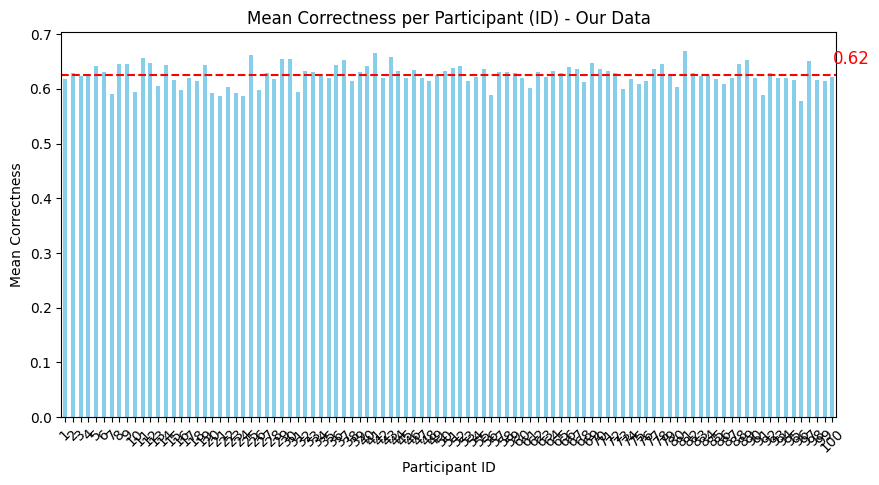

In [24]:
# === Plot the mean correctness versus ID ===
mean_correctness = final_df.groupby("ID")["correct"].mean()
mean_of_means = mean_correctness.mean()

plt.figure(figsize=(10, 5))
mean_correctness.plot(kind="bar", color="skyblue")
plt.axhline(mean_of_means, color="red", linestyle="--", label=f"Mean of Means: {mean_of_means:.2f}")
plt.text(len(mean_correctness) - 1, mean_of_means + 0.02, f"{mean_of_means:.2f}", color="red", fontsize=12)

if (test_type.startswith("without") and test_type.endswith("ms")) or (test_type == "test_model"):
    plt.title(f"Mean Correctness per Participant (ID){test_type_title}")
else : plt.title(f"Mean Correctness per Participant (ID) - Our Data")
plt.xlabel("Participant ID")
plt.ylabel("Mean Correctness")
plt.xticks(rotation=45)
if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/mean_correctness_per_participant.png', bbox_inches="tight")
plt.show()

### Plot Mean Correctness versus isi_ms

In [25]:
# === Plot the mean correctness versus isi_ms for all experiments except simulations ===
if test_type != 'test_model' and not test_type.startswith("simulation"):
    mean_correctness = final_df.groupby("isi_ms")["correct"].mean()
    mean_of_means = mean_correctness.mean()

    plt.figure(figsize=(10, 5))
    mean_correctness.plot(kind="bar", color="skyblue")
    plt.axhline(mean_of_means, color="red", linestyle="--", label=f"Mean of Means: {mean_of_means:.2f}")
    plt.text(len(mean_correctness) - 1, mean_of_means + 0.02, f"{mean_of_means:.2f}", color="red", fontsize=12)

    plt.title(f"Mean Correctness per Time Delay{test_type_title}")
    plt.xlabel("Time Delay")
    plt.ylabel("Mean Correctness")
    plt.xticks(rotation=45)
    if save_data:
        plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/mean_correctness_per_time_delay.png', bbox_inches="tight")
    plt.show()

### Verify Congruence

In [26]:
# === Compute congruence to internal and external variables ===

# Compute int_var_congruent:
# - when int_var < 0 and resp = 0 → congruent
# - when int_var > 0 and resp = 1 → congruent
final_df[f"{int_var}_congruent"] = np.where(
    ((final_df[int_var] < 0) & (final_df["resp"] == 0)) |
    ((final_df[int_var] > 0) & (final_df["resp"] == 1)),
    1,
    0
)

# Compute ext_var_congruent:
# - when ext_var > 0 and resp = 0 → congruent
# - when ext_var < 0 and resp = 1 → congruent
final_df[f"{ext_var}_congruent"] = np.where(
    ((final_df[f"{ext_var}"] < 0) & (final_df["resp"] == 0)) |
    ((final_df[f"{ext_var}"] > 0 ) & (final_df["resp"] == 1)),
    1,
    0
)


In [27]:
# === Set the parameters for calculating and plotting congruence ===
selected_id = 1     # by default, from 1 to 6
selected_block = 1  # by default, from 1 to 10
window_size = 5     # ±5 trials

#### For all trials

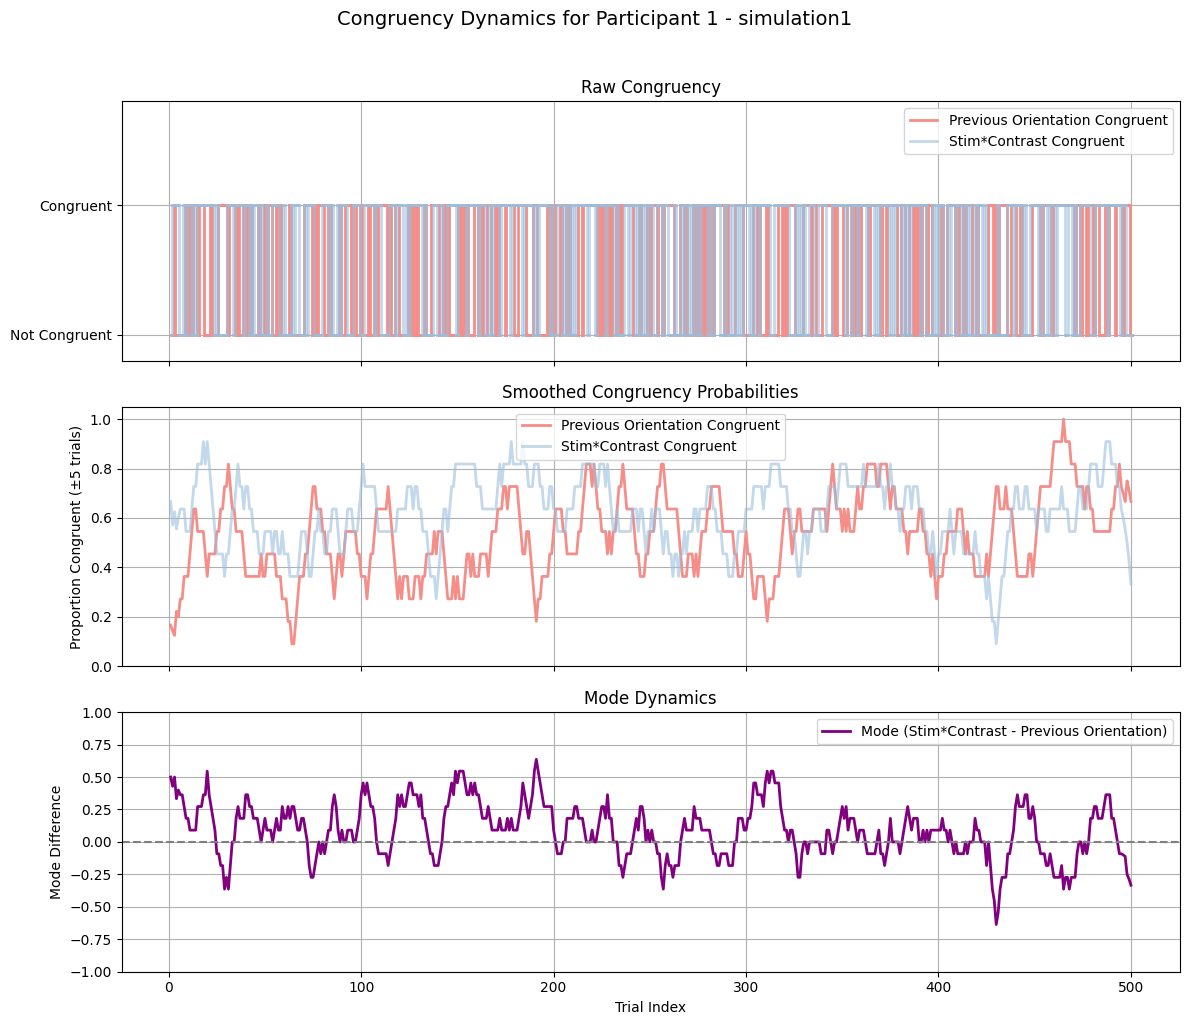

In [28]:
# === Plot congruence for all trials of a certain ID ===
df_congruence = final_df[(final_df["ID"] == selected_id)].copy()
df_congruence.reset_index(drop=True, inplace=True)

x_alltrials = df_congruence["trial"].values
y1 = df_congruence[f"{int_var}_congruent"].values
y2 = df_congruence[f"{ext_var}_congruent"].values

def draw_step_signal(ax, x, y, color, alpha=1):
    for i in range(len(x) - 1):
        ax.plot([x[i]-0.5, x[i]+0.5], [y[i], y[i]], color=color, linewidth=2, alpha=alpha)
        if y[i] == y[i+1]:
            ax.plot([x[i]+0.5, x[i+1]+0.5], [y[i], y[i+1]], color=color, linewidth=2, alpha=alpha)
        else:
            ax.vlines(x[i]+0.5, 0, 1, colors=color, linewidth=2, alpha=alpha)
            ax.plot([x[i]+0.5, x[i+1]+0.5], [y[i+1], y[i+1]], color=color, linewidth=2, alpha=alpha)

def smooth_congruency(arr, window):
    return np.array([
        np.mean(arr[max(0, i - window):min(len(arr), i + window + 1)])
        for i in range(len(arr))
    ])

y1_smooth = smooth_congruency(y1, window_size)
y2_smooth = smooth_congruency(y2, window_size)
mode_alltrials = y2_smooth - y1_smooth

# === Plot all 3 in stacked subplots ===
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Step plot of raw congruencies
draw_step_signal(axs[0], x_alltrials, y1, color="#f58d88")
draw_step_signal(axs[0], x_alltrials, y2, color="#9bbedc", alpha=0.6)
axs[0].set_ylim(-0.2, 1.8)
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Not Congruent", "Congruent"])
axs[0].set_title("Raw Congruency")
legend_elements = [
    Line2D([0], [0], color='#f58d88', lw=2, label=f'{int_var_title} Congruent'),
    Line2D([0], [0], color='#9bbedc', lw=2, label=f'{ext_var_title} Congruent', alpha=0.6)
]
axs[0].legend(handles=legend_elements)
axs[0].grid(True)

# 2. Smoothed probabilities
axs[1].plot(x_alltrials, y1_smooth, label=f'{int_var_title} Congruent', color="#f58d88", linewidth=2)
axs[1].plot(x_alltrials, y2_smooth, label=f"{ext_var_title} Congruent", color="#9bbedc", linewidth=2, alpha=0.6)
axs[1].set_ylim(0, 1.05)
axs[1].set_ylabel("Proportion Congruent (±5 trials)")
axs[1].set_title("Smoothed Congruency Probabilities")
axs[1].legend()
axs[1].grid(True)

# 3. Mode
axs[2].plot(x_alltrials, mode_alltrials, color="purple", linewidth=2, label=f"Mode ({ext_var_title} - {int_var_title})")
axs[2].axhline(0, color="gray", linestyle="--", linewidth=1.5)
axs[2].set_ylim(-1, 1)
axs[2].set_xlabel("Trial Index")
axs[2].set_ylabel("Mode Difference")
axs[2].set_title("Mode Dynamics")
axs[2].legend()
axs[2].grid(True)

plt.suptitle(f"Congruency Dynamics for Participant {selected_id}{test_type_title}", fontsize=14, y=1.02)
plt.tight_layout()

if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/congruency_alltrials.png', bbox_inches="tight")

plt.show()


#### For one block

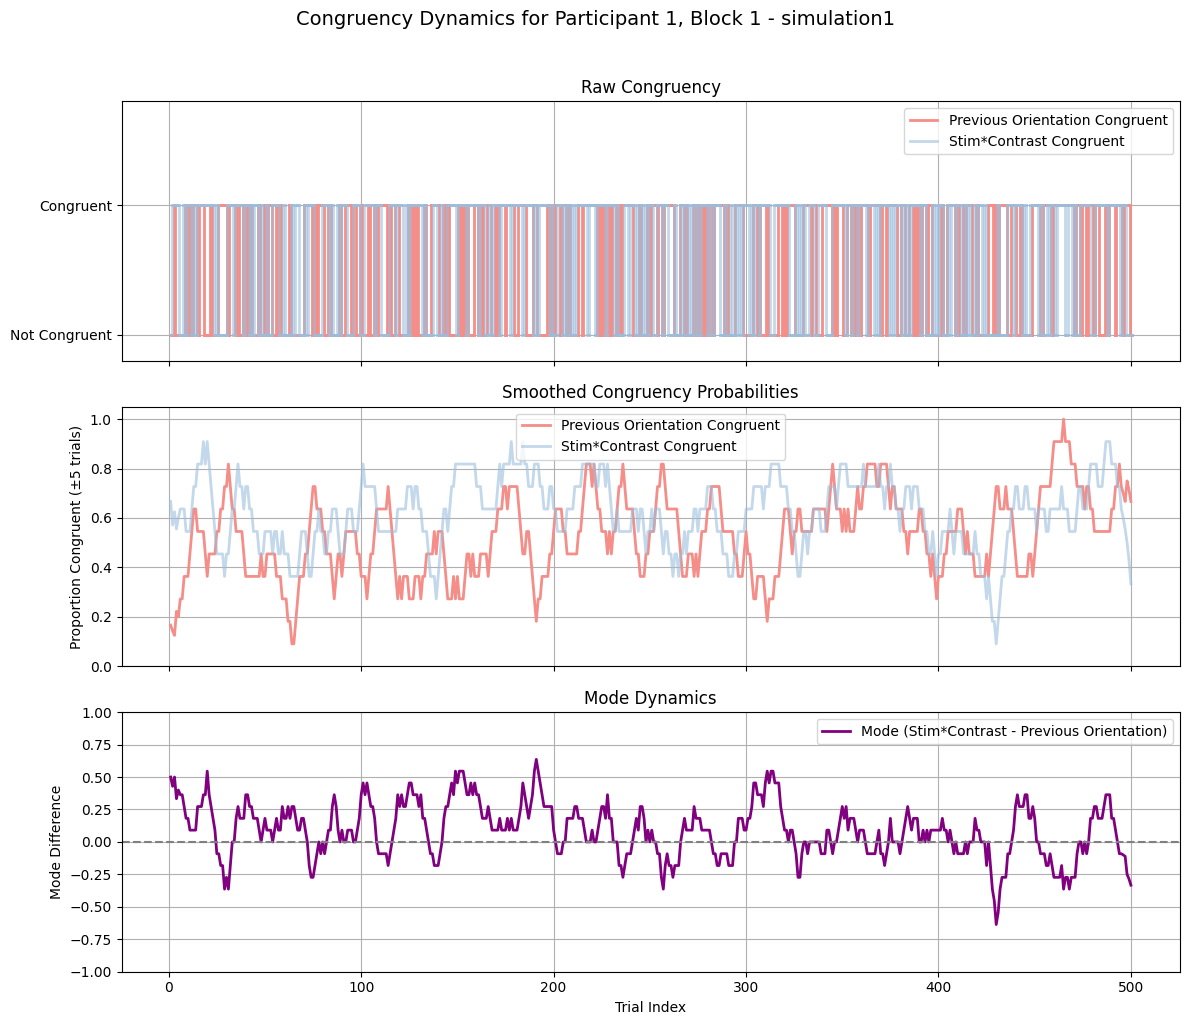

In [29]:
# === Plot congruence for one block of a certain ID ===
df_congruence = final_df[(final_df["ID"] == selected_id) & (final_df["block"] == selected_block)].copy()
df_congruence.reset_index(drop=True, inplace=True)

x_block = df_congruence["trial"].values
y1 = df_congruence[f"{int_var}_congruent"].values
y2 = df_congruence[f"{ext_var}_congruent"].values

y1_smooth = smooth_congruency(y1, window_size)
y2_smooth = smooth_congruency(y2, window_size)
mode_block = y2_smooth - y1_smooth

# === Plot all 3 in stacked subplots ===
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Step plot of raw congruencies
draw_step_signal(axs[0], x_block, y1, color="#f58d88")
draw_step_signal(axs[0], x_block, y2, color="#9bbedc", alpha=0.6)
axs[0].set_ylim(-0.2, 1.8)
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Not Congruent", "Congruent"])
axs[0].set_title("Raw Congruency")
legend_elements = [
    Line2D([0], [0], color='#f58d88', lw=2, label=f'{int_var_title} Congruent'),
    Line2D([0], [0], color='#9bbedc', lw=2, label=f'{ext_var_title} Congruent', alpha=0.6)
]
axs[0].legend(handles=legend_elements)
axs[0].grid(True)

# 2. Smoothed probabilities
axs[1].plot(x_block, y1_smooth, label=f"{int_var_title} Congruent", color='#f58d88', linewidth=2)
axs[1].plot(x_block, y2_smooth, label=f"{ext_var_title} Congruent", color="#9bbedc", linewidth=2, alpha=0.6)
axs[1].set_ylim(0, 1.05)
axs[1].set_ylabel("Proportion Congruent (±5 trials)")
axs[1].set_title("Smoothed Congruency Probabilities")
axs[1].legend()
axs[1].grid(True)

# 3. Mode
axs[2].plot(x_block, mode_block, color="purple", linewidth=2, label=f"Mode ({ext_var_title} - {int_var_title})")
axs[2].axhline(0, color="gray", linestyle="--", linewidth=1.5)
axs[2].set_ylim(-1, 1)
axs[2].set_xlabel("Trial Index")
axs[2].set_ylabel("Mode Difference")
axs[2].set_title("Mode Dynamics")
axs[2].legend()
axs[2].grid(True)

plt.suptitle(f"Congruency Dynamics for Participant {selected_id}, Block {selected_block}{test_type_title}", fontsize=14, y=1.02)
plt.tight_layout()

if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/congruency_sample.png', bbox_inches="tight")

plt.show()


#### Mode analysis

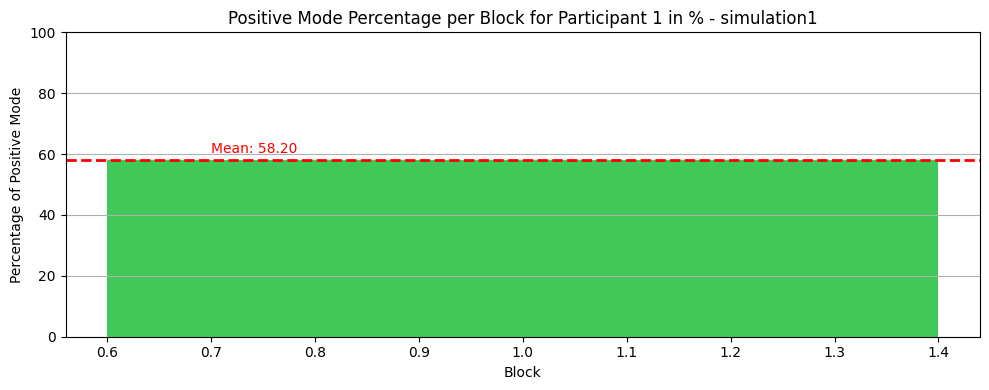

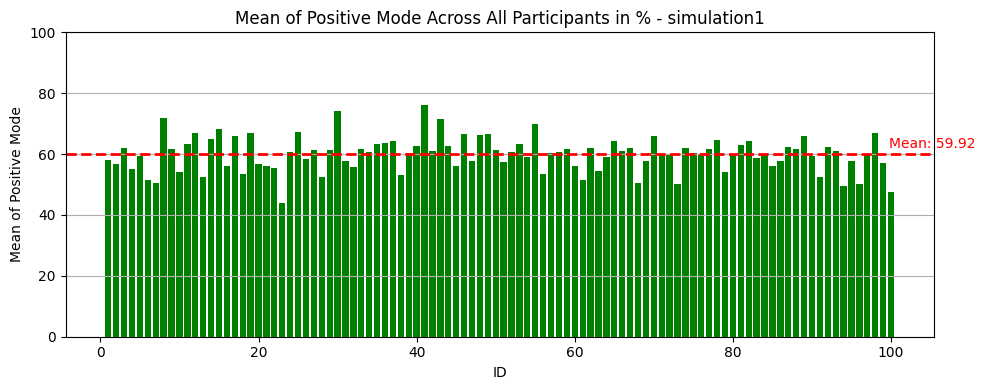

In [30]:
# === Mode analysis ===
all_ids = final_df["ID"].unique()

# Function to compute percentage of positive mode per block for a given ID
def compute_blockwise_positive_mode(df, id_val):
    df_id = df[df["ID"] == id_val]
    blocks = sorted(df_id["block"].unique())
    positive_percentages = []

    for block in blocks:
        df_block = df_id[df_id["block"] == block]
        y1 = df_block[f"{int_var}_congruent"].values
        y2 = df_block[f"{ext_var}_congruent"].values
        y1_smooth = smooth_congruency(y1, window_size)
        y2_smooth = smooth_congruency(y2, window_size)
        mode = y2_smooth - y1_smooth
        percent_positive = np.sum(mode > 0) / len(mode) * 100
        positive_percentages.append(percent_positive)

    return blocks, positive_percentages

# ---- Step 1: Plot per-block percentage of positive mode for selected ID ----
blocks, percentages = compute_blockwise_positive_mode(final_df, selected_id)

plt.figure(figsize=(10, 4))
plt.bar(blocks, percentages, color="#40c958")
plt.ylim(0, 100)
plt.xlabel("Block")
plt.ylabel("Percentage of Positive Mode")
plt.title(f"Positive Mode Percentage per Block for Participant {selected_id} in %{test_type_title}")
plt.grid(axis='y')
mean_positive_mode_id = np.nanmean(percentages)
plt.axhline(mean_positive_mode_id, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_positive_mode_id:.2f}")
plt.text(blocks[-1] - 0.3, mean_positive_mode_id + 2, f"Mean: {mean_positive_mode_id:.2f}", color="red")

plt.tight_layout()
if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/mode_per_block.png', bbox_inches="tight")
plt.show()

# ---- Step 2: Compute mean positive mode for all IDs ----
mean_positive_modes_all_ids = []

for id_val in all_ids:
    _, percentages = compute_blockwise_positive_mode(final_df, id_val)
    mean_val = np.nanmean(percentages)
    mean_positive_modes_all_ids.append(mean_val)

# ---- Step 3: Plot mean positive mode for all IDs ----
plt.figure(figsize=(10, 4))
plt.bar(all_ids, mean_positive_modes_all_ids, color="green")
plt.ylim(0, 100)
plt.xlabel("ID")
plt.ylabel("Mean of Positive Mode")
plt.title(f"Mean of Positive Mode Across All Participants in %{test_type_title}")
overall_mean = np.nanmean(mean_positive_modes_all_ids)
plt.axhline(overall_mean, color="red", linestyle="--", linewidth=2, label=f"Mean = {overall_mean:.2f}")
plt.text(all_ids[-1] - 0.3, overall_mean + 2, f"Mean: {overall_mean:.2f}", color="red")

plt.grid(axis='y')
plt.tight_layout()
if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/mode_per_ID.png', bbox_inches="tight")
plt.show()


# Initialize GLM-HMM

In [31]:
# === Set the parameters of the GLM-HMM ===
obs_dim = 1             # number of observed dimensions
num_categories = 2      # number of categories for output
if bias == True:
    input_dim = 3       # input dimensions
else: 
    input_dim = 2 
N_iters = 500           # maximum number of EM iterations. Fitting will stop earlier if the increase in log-likelihood (LL) is below the tolerance specified by the tolerance parameter.


In [32]:
# === Prepare inputs ===
inpts = []
choices = []
participants = final_df["ID"].unique()

for load_idx in participants:
    this_data = final_df.loc[final_df['ID'] == load_idx].copy()

    num_trials_per_sess = len(this_data)

    new_inpts = []
    new_choices = []

    new_inpts = np.ones((num_trials_per_sess, input_dim))
    new_inpts[:, 0] = this_data[ext_var].copy()
    new_inpts[:, 1] = this_data[int_var].copy()
    if bias == True:
        new_inpts[:, 2] = np.ones(this_data.shape[0])
    inpts.append(new_inpts)

    new_choices = this_data['resp'].copy()
    new_choices = np.atleast_2d(new_choices).T
    choices.append(new_choices) 

# Fit at group-level in one-state GLM-HMM

In [33]:
# === Fit one state GLM-HMM at group level ===
num_states = 1      # Number of discrete states 
n_iter = 100        # Number of model restarts

transition_alpha = 1    # Hyperparameter to control the probabilities of moving from one hidden state to another.
prior_sigma = 10        # Hyperparameter to control the standard deviation of Gaussian prior on GLM weights.

if bias == True:
    iter_array = np.full([n_iter, 3], np.nan)
else:
    iter_array = np.full([n_iter, 2], np.nan)
    
for idx in range(n_iter):
    
    one_state_glmhmm = HMM(num_states, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))
    print(one_state_glmhmm.params)
    one_state_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
    
    if bias == True:
        iter_array[idx,] = one_state_glmhmm.observations.params.reshape((1,3))
    else:
        iter_array[idx,] = one_state_glmhmm.observations.params.reshape((1,2))


((array([-0.]),), (array([[0.]]),), array([[[ 0.74159174,  1.55291372, -2.2683282 ]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 1.33354538,  0.95008842, -0.15135721]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 1.26611853, -0.50587654,  2.54520078]]]))
((array([-0.]),), (array([[0.]]),), array([[[1.08081191, 0.44386323, 0.33367433]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.18158257,  1.41020463, -0.37447169]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 0.27519832, -2.55298982,  0.6536186 ]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.24214951,  1.51439128, -0.3330574 ]]]))
((array([-0.]),), (array([[0.]]),), array([[[0.04736482, 1.53277921, 1.46935877]]]))
((array([-0.]),), (array([[0.]]),), array([[[-1.078278  ,  1.39547227,  1.78748405]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.56951726,  1.23029068,  1.20237985]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.38586334, -0.77576235,  0.99571135]]]))
((array([-0.]),), (array([[0.]]),), ar

1. The calculated parameters of GLM-HMM model for each model restart are:
- the log-initial state probabilities: the log of the probabilities of starting in each hidden state.
- the log-transition matrix: the log of the probabilities of moving from one hidden state to another.
- the GLM weights (for inputs).


2. Important: the calculated GLM weights are from the opposite sign of the GLM weights we are used to see, i.e. when we consider this formula:  

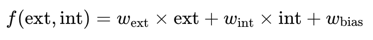  
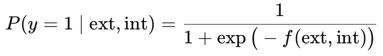

Indeed, because of how it is coded in ssm, the GLM-HMM model computes the log-probability of class 0 (when response = 0) relative to class 1 (when response = 1): 

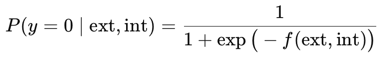

For that reason, we always inverse the sign of the weights parameters when we want to analyse them.

In [68]:
# === Save results ===
if bias == True:
    df_iter_array = pd.DataFrame(iter_array, columns = [ext_var, int_var, 'bias'])
else:
    df_iter_array = pd.DataFrame(iter_array, columns = [ext_var, int_var])
    
if save_data:
    df_iter_array.to_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/one_level_HMM_params.csv', index = False) 

In [35]:
# === Print mean GLM weights when 1 state ===
df_iter_array = pd.read_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/one_level_HMM_params.csv')
params_for_initalization = df_iter_array.mean().values
print(params_for_initalization)

[-19.70596717  -0.11119078  -0.20589581]


# Fit multi-state GLM-HMMs at group-level and compare BIC

In [36]:
# === Compare models based on BIC ===
max_num_states =  2     # number of discrete states

N_iters = 500           # maximum number of EM iterations. Fitting will stop earlier if the increase in log-likelihood (LL) is below the tolerance specified by the tolerance parameter.
transition_alpha = 1    # Hyperparameter to control the probabilities of moving from one hidden state to another.
prior_sigma = 10        # Hyperparameter to control the standard deviation of Gaussian prior on GLM weights.

BIC = []
for state_idx in range(max_num_states): 
    print(state_idx)
    compare_glmhmm = HMM(state_idx+1, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))

    
    _ = compare_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
    n_total_params = np.concatenate(compare_glmhmm.observations.params).size + np.concatenate(compare_glmhmm.transitions.params).size
    
    # Flatten choices and inpts to calculate log likelihood correctly
    flattened_choices = np.concatenate(choices)
    flattened_inpts = np.concatenate(inpts)

    new_BIC = np.log(np.size(flattened_choices))*n_total_params - 2*compare_glmhmm.log_likelihood(choices, inputs=inpts)
    
    if save_data:
        pd.DataFrame(np.append(new_BIC, np.concatenate(compare_glmhmm.observations.params))).to_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/Full_model_outcome_states_' + str(state_idx + 1) + '.csv', index = False)

    BIC = np.append(BIC, new_BIC) 
    print(compare_glmhmm.observations.params)

df_BIC = pd.DataFrame({'BIC': BIC, 'num_states': np.arange(max_num_states) + 1})

if save_data:
    df_BIC.to_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/BIC_across_models.csv', index = False)

0
[[[-19.70787803  -0.11119763  -0.2059089 ]]]
1
[[[-18.98492665   0.02975943  -0.24019676]]

 [[-20.60054944  -0.25318873  -0.17260005]]]


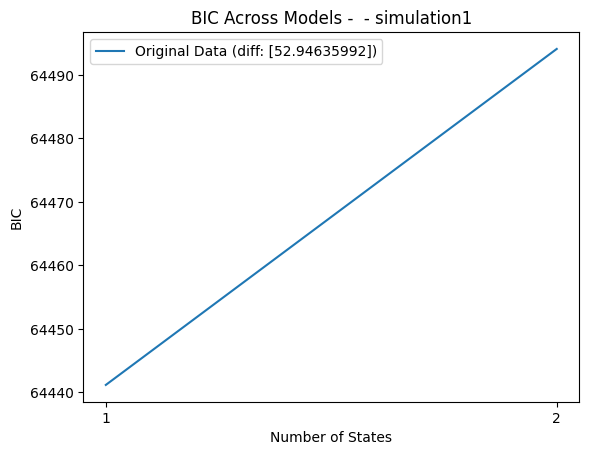

In [69]:
# === Plot BIC when 1 or 2 states ===
df_BIC = pd.read_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/BIC_across_models.csv')
bic_diff = np.diff(df_BIC.BIC)

plt.plot(df_BIC['num_states'], df_BIC['BIC'], label=f'Original Data (diff: {bic_diff})')
plt.title(f'BIC Across Models - {test_type_title}')
plt.xlabel('Number of States')
plt.ylabel('BIC')
plt.legend()
plt.xticks([1, 2])
if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/BIC_across_models.png', bbox_inches='tight')
plt.show()

# Fit permuted multi-state GLM-HMMs at group-level and compare BIC

In [39]:
# === Permutation analysis when 1 or 2 states ===
if not test_type.startswith("simulation"):  # In the simulations, order between trials has no significance (because of the experiment itself).
    n_perm = 100
    BIC_permuted = []

    for perm_idx in range(n_perm):
        permuted_choices = []
        permuted_inpts = []
        
        for i in range(len(choices)):
            perm_indices = npr.permutation(choices[i].shape[0])
            permuted_choices.append(choices[i][perm_indices])
            permuted_inpts.append(inpts[i][perm_indices])
         
        for state_idx in range(max_num_states):
            print(f"Permutation {perm_idx}, State {state_idx}")
            permuted_glmhmm = HMM(state_idx + 1, obs_dim, input_dim, 
                                    observations="input_driven_obs", 
                                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                                    transitions="sticky", 
                                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))

            _ = permuted_glmhmm.fit(permuted_choices, inputs=permuted_inpts, method="em", num_iters=N_iters, initialize=True, tolerance=10**-4, verbose=False)

            n_total_params = np.concatenate(permuted_glmhmm.observations.params).size + np.concatenate(permuted_glmhmm.transitions.params).size

            # Compute log likelihood
            log_likelihood = permuted_glmhmm.log_likelihood(permuted_choices, inputs=permuted_inpts)

            # Compute BIC
            new_BIC = np.log(len(flattened_choices)) * n_total_params - 2 * log_likelihood
            BIC_permuted.append({'perm_idx': perm_idx, 'state_idx': state_idx + 1, 'BIC': new_BIC})

    df_BIC_permuted = pd.DataFrame(BIC_permuted)
    if save_data:
        df_BIC_permuted.to_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/BIC_permuted_across_models.csv', index=False)

In [40]:
# === Plot the permutation analysis ===
if not test_type.startswith("simulation"):
    # Average BIC across permutations
    df_BIC_permuted_avg = df_BIC_permuted.groupby('state_idx').agg({'BIC': 'mean'}).reset_index()
    bic_diff = np.diff(df_BIC['BIC'])
    bic_diff_permuted = np.diff(df_BIC_permuted_avg['BIC'])

    plt.plot(df_BIC['num_states'], df_BIC['BIC'], label=f'Original Data (diff: {bic_diff})')
    plt.plot(df_BIC_permuted_avg['state_idx'], df_BIC_permuted_avg['BIC'], label=f'Permuted Data (Avg) (diff: {bic_diff_permuted})', linestyle='--')
    plt.xlabel('Number of States')
    plt.ylabel('BIC')
    plt.legend()
    plt.title(f'BIC Comparison Between Original and Permuted Data{test_type_title}')
    plt.xticks([1, 2])
    if save_data:
        plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/BIC_comparison.png', bbox_inches='tight')
    plt.show()

# Fit two-state GLM-HMMs 

In [41]:
# === Fit two-state GLM-HMMs ===
# Set the parameters of the GLM-HMM
num_states =  2         # number of discrete states
obs_dim = 1             # number of observed dimensions
num_categories = 2      # number of categories for output
if bias == True:
    input_dim = 3
else:
    input_dim = 2       # input dimensions

N_iters = 500           # maximum number of EM iterations. Fitting will stop earlier if the increase in log-likelihood (LL) is below the tolerance specified by the tolerance parameter.

#  Make a GLM-HMM
transition_alpha = 1    # Hyperparameter to control the probabilities of moving from one hidden state to another.
prior_sigma = 10        # Hyperparameter to control the standard deviation of Gaussian prior on GLM weights.

n_iter = 10             # Number of model restarts
if bias == True:
    parameters_ext_int = np.full([n_iter, 10], np.nan) 
else:
    parameters_ext_int = np.full([n_iter, 8], np.nan)

for idx in range(n_iter):
    print(idx)
    glmhmm = HMM(num_states, obs_dim, input_dim, 
                observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                transitions="sticky", 
                transition_kwargs=dict(alpha=transition_alpha, kappa=0))
    
    # === to use if you want to initialize the parameters with the ones found when one state only ===
    #if bias == True:
    #    glmhmm.observations.params =  np.tile(params_for_initalization, (num_states,1)).reshape(num_states, 1, 3)
    #else:
    #    glmhmm.observations.params =  np.tile(params_for_initalization, (num_states,1)).reshape(num_states, 1, 2) 
    _ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)

    # We choose the external state as state 1: the state where the ext_var coefficient (first input correspond to 0) is the highest between the two found states.
    index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0]) 
    index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])
    parameters_ext_int[idx,] = np.concatenate((-glmhmm.observations.params[index_ext,:], -glmhmm.observations.params[index_int,:], glmhmm.transitions.params[0].reshape(1,4)), axis = 1)
    del(glmhmm)


0
1
2
3
4
5
6
7
8
9


In [42]:
# === Create panda dataframe for the results ===
if bias == True:
    df_two_state_init = pd.DataFrame(parameters_ext_int, columns = [f'{ext_var}_ext', f'{int_var}_ext', 'bias_ext',
                                                                f'{ext_var}_int', f'{int_var}_int', 'bias_int',
                                                                 'AA', 'AB', 'BA', 'BB']) 
else:
    df_two_state_init = pd.DataFrame(parameters_ext_int, columns = [f'{ext_var}_ext', f'{int_var}_ext',
                                                                f'{ext_var}_int', f'{int_var}_int',
                                                                 'AA', 'AB', 'BA', 'BB']) 


In [70]:
# === Save the results ===
if save_data:
    df_two_state_init.to_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/two_state_init_param.csv', index = False)

## Weights Coefficients

In [71]:
# === Read the results ===
df_two_state_init = pd.read_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/two_state_init_param.csv')

In [72]:
# === Print the mean of the results ===
df_two_state_init.mean()

stim*contrast_ext    20.312495
previous_ext          0.193547
bias_ext              0.188417
stim*contrast_int    18.505155
previous_int         -0.070217
bias_int              0.240833
AA                   -0.025159
AB                   -4.013704
BA                   -3.569605
BB                   -0.033681
dtype: float64

In [73]:
# === Print the ratios of probabilities of influence of both variables for both states ===
external_ratio = np.exp(df_two_state_init.mean()[f'{ext_var}_ext'])/np.exp(df_two_state_init.mean()[f'{int_var}_ext'])
internal_ratio = np.exp(df_two_state_init.mean()[f'{ext_var}_int'])/np.exp(df_two_state_init.mean()[f'{int_var}_int'])
print(f"External state ratio ({ext_var}/{int_var}):", external_ratio)
print(f"Internal state ratio ({ext_var}/{int_var}):", internal_ratio)

o_external_ratio = 100*external_ratio/(external_ratio+1)
o_internal_ratio = 100*internal_ratio/(internal_ratio+1)
print(f"External state ratio in % ({ext_var}/{int_var}):", o_external_ratio, "/", 100-o_external_ratio)
print(f"Internal state ratio in % ({ext_var}/{int_var}):", o_internal_ratio, "/", 100-o_internal_ratio)

External state ratio (stim*contrast/previous): 546446975.8325316
Internal state ratio (stim*contrast/previous): 116729697.56747726
External state ratio in % (stim*contrast/previous): 99.99999981699963 / 1.830003668601421e-07
Internal state ratio in % (stim*contrast/previous): 99.99999914332 / 8.566800033804611e-07


In [74]:
# === Load parameters from results ===
df_two_state_init = pd.read_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/two_state_init_param.csv')
param_init_ext_int = df_two_state_init.mean().values

if bias == True:
    recovered_weights = -param_init_ext_int[0:6].reshape(2,1,3)         
    recovered_trans_mat = np.exp(param_init_ext_int[6:10].reshape(2,2)) 
else:
    recovered_weights = -param_init_ext_int[0:4].reshape(2,1,2)    
    recovered_trans_mat = np.exp(param_init_ext_int[4:8].reshape(2,2))     

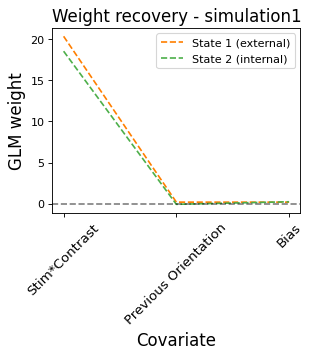

In [75]:
# === Plot weights for each variable ===
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8',  '#8B0000', '#000000']
if test_type == "test_model":
    for k in range(num_states):
        if k==0:
            plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                        lw=1.5,  label = f"State 1 ({orientation_perc_external* 100:.0f}o-{prev_resp_perc_external* 100:.0f}pr)", linestyle = '--') #State 1 (70o-30pr)
        else:
            plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                        lw=1.5,  label = f'State 2 ({orientation_perc_internal* 100:.0f}o-{prev_resp_perc_internal* 100:.0f}pr)', linestyle = '--') #State 2 (10o-90pr)
else:
    for k in range(num_states):
        if k==0:
            plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                        lw=1.5,  label = "State 1 (external)", linestyle = '--')
        else:
            plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                        lw=1.5,  label = 'State 2 (internal)', linestyle = '--') 
        
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariate", fontsize=15)
if bias == True:
    plt.xticks([0, 1, 2], [f'{ext_var_title}', f'{int_var_title}', 'Bias'], fontsize=12, rotation=45)
else:
    plt.xticks([0, 1], [f'{ext_var_title}', f'{int_var_title}'], fontsize=12, rotation=45) 
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title(f"Weight recovery{test_type_title}", fontsize=15)
if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/weight_recovery.png', bbox_inches='tight')
plt.show()

## State Transition Matrix

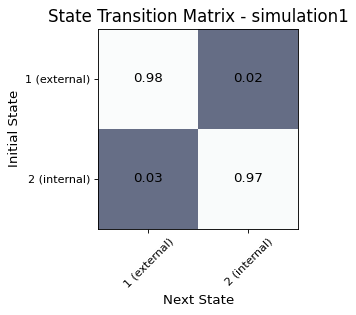

In [76]:
# === Print state transition matrix ===
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)

if test_type == "test_model":
    plt.xticks(range(0, num_states), (f'1 ({orientation_perc_external* 100:.0f}o-{prev_resp_perc_external* 100:.0f}pr)',
                                      f'2 ({orientation_perc_internal* 100:.0f}o-{prev_resp_perc_internal* 100:.0f}pr)'),   #'1 (70o-30pr)', '2 (10o-90pr)'
                                      fontsize=10, rotation=45)
    plt.yticks(range(0, num_states), (f'1 ({orientation_perc_external* 100:.0f}o-{prev_resp_perc_external* 100:.0f}pr)',
                                      f'2 ({orientation_perc_internal* 100:.0f}o-{prev_resp_perc_internal* 100:.0f}pr)'),
                                      fontsize=10) 
else:
    plt.xticks(range(0, num_states), ('1 (external)', '2 (internal)'), fontsize=10, rotation=45)
    plt.yticks(range(0, num_states), ('1 (external)', '2 (internal)'), fontsize=10) 

plt.ylim(num_states - 0.5, -0.5)
plt.xlabel('Next State', fontsize=12)
plt.ylabel('Initial State', fontsize=12)
plt.title(f"State Transition Matrix{test_type_title}", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)
if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/transitions.png', bbox_inches='tight')
plt.show()

## Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [77]:
# === Run average model with results as initializing parameters ===
prior_sigma = 10

glmhmm = HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))

if bias == True:
    glmhmm.init_state_distn.params = np.log([0.5, 0.5, 0.5]) 
    glmhmm.observations.params = -param_init_ext_int[0:6].reshape(2,1,3)
    glmhmm.transitions.params = (param_init_ext_int[6:10].reshape(2,2),)
else:    
    glmhmm.init_state_distn.params = np.log([0.5, 0.5])
    glmhmm.observations.params = -param_init_ext_int[0:4].reshape(2,1,2)
    glmhmm.transitions.params = (param_init_ext_int[4:8].reshape(2,2),)

_ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = False, tolerance=10**-4, verbose = False)
print(-glmhmm.observations.params)
index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])

[[[20.47311615  0.19174762  0.19281001]]

 [[18.03065376 -0.08965005  0.24066163]]]


In [78]:
# === Get expected states ===
posterior_probs = [glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choices, inpts)]

### For all trials

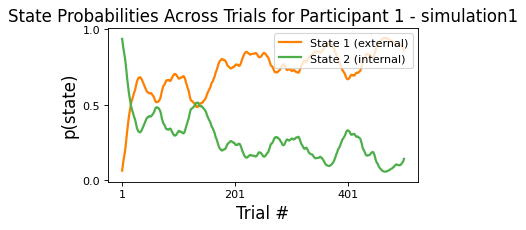

In [79]:
# === Plot probabilities across all trials for one participant ===
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
n_initial = x_alltrials[0]-1
n_final = x_alltrials[-1]
if test_type == 'test_model':
    sess_id = 0     # only 0 here as 'test_model' considers whole data as 1 ID
else:
    sess_id = 0     # you can choose any index between 0 and num_participants-1=6-1=5
if test_type != 'test_model':
    for k in range(num_states):
        if k==0:
            plt.plot(posterior_probs[sess_id][n_initial:n_final, k], label="State 1 (external)", lw=2,
                color=cols[k])
        else:
            plt.plot(posterior_probs[sess_id][n_initial:n_final, k], label="State 2 (internal)", lw=2, 
                color=cols[k])
else:   
    for k in range(num_states):
        if k==0:
            plt.plot(posterior_probs[sess_id][1:9000, k], label=f"State 1 ({fraction_even:.2f})", lw=2, #State 1 (36%)
                color=cols[k])
        else:
            plt.plot(posterior_probs[sess_id][1:9000, k], label=f"State 2 ({fraction_odd:.2f})", lw=2, #State 2 (64%)
                color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("Trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)
plt.legend(loc="upper right", fontsize=10, title_fontsize=12)
plt.xticks(ticks=np.arange(0, n_final - n_initial, 200), labels=np.arange(n_initial+1, n_final, 200))

if test_type == 'test_model':
    plt.title(f"State Probabilities Across Trials - test", fontsize=15)
else:
    plt.title(f"State Probabilities Across Trials for Participant {sess_id+1}{test_type_title}", fontsize=15)

if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/probabilities_alltrials.png', bbox_inches='tight')
plt.show()

### For one block

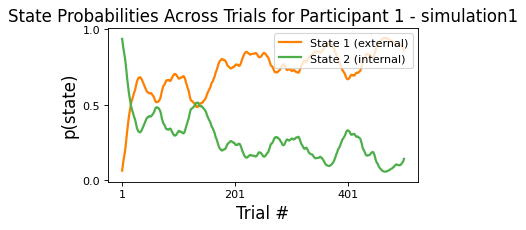

In [80]:
# === Plot probabilities across one block for one participant ===
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
n_initial = x_block[0]-1
n_final = x_block[-1]
if test_type == 'test_model':
    sess_id = 0     # only 0 here as 'test_model' considers whole data as 1 ID
else:
    sess_id = 0     # you can choose any index between 0 and num_participants-1=6-1=5
if test_type != 'test_model':
    for k in range(num_states):
        if k==0:
            plt.plot(posterior_probs[sess_id][n_initial:n_final, k], label="State 1 (external)", lw=2,
                color=cols[k])
        else:
            plt.plot(posterior_probs[sess_id][n_initial:n_final, k], label="State 2 (internal)", lw=2, 
                color=cols[k])
else:   
    for k in range(num_states):
        if k==0:
            plt.plot(posterior_probs[sess_id][1:9000, k], label=f"State 1 ({fraction_even:.2f})", lw=2, #State 1 (36%)
                color=cols[k])
        else:
            plt.plot(posterior_probs[sess_id][1:9000, k], label=f"State 2 ({fraction_odd:.2f})", lw=2, #State 2 (64%)
                color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("Trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)
plt.legend(loc="upper right", fontsize=10, title_fontsize=12)
plt.xticks(ticks=np.arange(0, n_final - n_initial, 200), labels=np.arange(n_initial+1, n_final, 200))

if test_type == 'test_model':
    plt.title(f"State Probabilities Across Trials - test", fontsize=15)
else:
    plt.title(f"State Probabilities Across Trials for Participant {sess_id+1}{test_type_title}", fontsize=15)

if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/probabilities_block.png', bbox_inches='tight')
plt.show()

## Plot congruency vs model

### For all trials

/var/folders/hc/f0q04dfj06d1b1f0nks6jk_00000gn/T/ipykernel_46939/245357354.py:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((0 + start, -1), end - start, 2.01, color=cols[state], edgecolor='none', alpha=0.2, zorder=0)


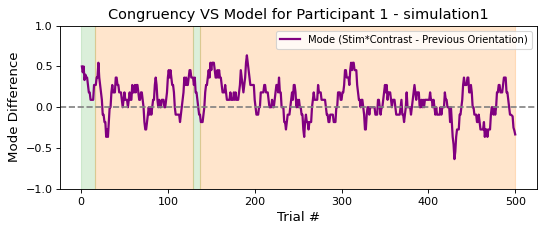

In [81]:
# === Plot probabilities VS congruency across all trials for one participant ===
fig, ax = plt.subplots(figsize=(7, 3), dpi=80)
n_initial = x_alltrials[0]-1
n_final = x_alltrials[-1]

ax.plot(x_alltrials, mode_alltrials, color="purple", linewidth=2, label=f"Mode ({ext_var_title} - {int_var_title})", zorder=1)
ax.axhline(0, color="gray", linestyle="--", linewidth=1.5)
ax.set_ylim(-1, 1)
ax.set_ylabel("Mode Difference", fontsize=12)
ax.tick_params(axis='y', labelsize=10)

state_sequence = np.argmax(posterior_probs[sess_id][0:n_final], axis=1)

change_points = [0]
for i in range(1, len(state_sequence)):
    if state_sequence[i] != state_sequence[i - 1]:
        change_points.append(i)
change_points.append(len(state_sequence))  

for i in range(len(change_points) - 1):
    start = change_points[i]
    end = change_points[i + 1]
    state = state_sequence[start]
    rect = plt.Rectangle((0 + start, -1), end - start, 2.01, color=cols[state], edgecolor='none', alpha=0.2, zorder=0)
    ax.add_patch(rect)

ax.set_xlabel("Trial #", fontsize=12)
plt.title(f"Congruency VS Model for Participant {sess_id+1}{test_type_title}", fontsize=13)
lines2, labels2 = ax.get_legend_handles_labels()
ax.legend(lines2, labels2, loc="upper right", fontsize=9, title_fontsize=11)

plt.tight_layout()

if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/congruencyvsmodel_alltrials.png', bbox_inches="tight")

plt.show()


### For one block

/var/folders/hc/f0q04dfj06d1b1f0nks6jk_00000gn/T/ipykernel_46939/2922996656.py:35: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((n_initial + start, -1), end - start, 2.01, color=cols[state], edgecolor='none', alpha=0.2, zorder=0)


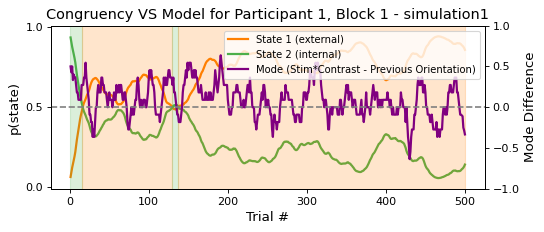

In [82]:
# === Plot probabilities VS congruency across one block for one participant ===
fig, ax1 = plt.subplots(figsize=(7, 3), dpi=80)

n_initial = x_block[0]-1
n_final = x_block[-1]

for k in range(num_states):
    label = "State 1 (external)" if k == 0 else "State 2 (internal)"
    ax1.plot(x_block, posterior_probs[sess_id][n_initial:n_final, k], label=label, lw=2, color=cols[k], zorder=1)

ax1.set_ylim(-0.01, 1.01)
ax1.set_yticks([0, 0.5, 1])
ax1.set_ylabel("p(state)", fontsize=12)
ax1.tick_params(axis='y', labelsize=10)

ax2 = ax1.twinx()
ax2.plot(x_block, mode_block, color="purple", linewidth=2, label=f"Mode ({ext_var_title} - {int_var_title})", zorder=1)
ax2.axhline(0, color="gray", linestyle="--", linewidth=1.5)
ax2.set_ylim(-1, 1)
ax2.set_ylabel("Mode Difference", fontsize=12)
ax2.tick_params(axis='y', labelsize=10)

state_sequence = np.argmax(posterior_probs[sess_id][n_initial:n_final], axis=1)

change_points = [0]
for i in range(1, len(state_sequence)):
    if state_sequence[i] != state_sequence[i - 1]:
        change_points.append(i)
change_points.append(len(state_sequence))  

for i in range(len(change_points) - 1):
    start = change_points[i]
    end = change_points[i + 1]
    state = state_sequence[start]
    rect = plt.Rectangle((n_initial + start, -1), end - start, 2.01, color=cols[state], edgecolor='none', alpha=0.2, zorder=0)
    ax2.add_patch(rect)

ax1.set_xlabel("Trial #", fontsize=12)

if n_initial != 0:
    plt.title(f"Congruency VS Model for Participant {sess_id+1} (Trials {n_initial+1}-{n_final+1}){test_type_title}", fontsize=13)
else:
    plt.title(f"Congruency VS Model for Participant {sess_id+1}, Block {selected_block}{test_type_title}", fontsize=13)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=9, title_fontsize=11)

plt.tight_layout()

if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/congruencyvsmodel_block.png', bbox_inches="tight")

plt.show()

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

## Fractional occupancy

In [83]:
# === Calculate state occupancies ===
# Concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# Get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# Now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

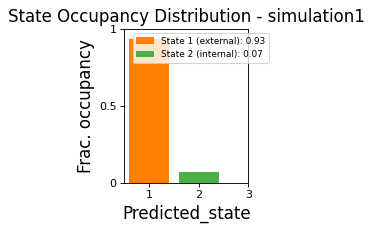

In [84]:
# === Plot state occupancies ===
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
if test_type == 'test_model':
    for z, occ in enumerate(state_occupancies):
        if z==0:
            plt.bar(z, occ, width = 0.8, color = cols[z], label=f'{fraction_even:.2f}: {occ:.2f}')  #36%
        else:
            plt.bar(z, occ, width = 0.8, color = cols[z], label=f'{fraction_odd:.2f}: {occ:.2f}')   #64%
else:
    for z, occ in enumerate(state_occupancies):
        if z==0:
            plt.bar(z, occ, width = 0.8, color = cols[z], label=f'State 1 (external): {occ:.2f}')
        else:
            plt.bar(z, occ, width = 0.8, color = cols[z], label=f'State 2 (internal): {occ:.2f}') 

plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('Predicted_state', fontsize = 15)
plt.ylabel('Frac. occupancy', fontsize=15)
plt.legend(loc="upper right", fontsize=8, title_fontsize=10, bbox_to_anchor=(1.2, 1))
plt.title(f"State Occupancy Distribution{test_type_title}", fontsize=15)
if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/fraction_occupancy.png', bbox_inches='tight')
plt.show()

In [85]:
# === Assign probabilities to each trial ===
final_df = final_df.assign(Gl_Prob_State_ext = posterior_probs_concat[:,index_ext])
final_df = final_df.assign(Gl_Prob_State_int = posterior_probs_concat[:,index_int])

In [86]:
# === Assign predicted state to each trial and save the final results ===
final_df['Predicted_state'] = final_df.apply(lambda row: 1 if row['Gl_Prob_State_ext'] > row['Gl_Prob_State_int'] else 2, axis=1)

if save_data:
    if test_type == 'test_model':
        final_df.to_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/Full_HMM_test_model_{fraction_odd * 100:.0f}.csv', index = False)
    else:
        final_df.to_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/Full_HMM_{test_type}.csv', index=False)

# Verifications

## Verify level of correctness for each state

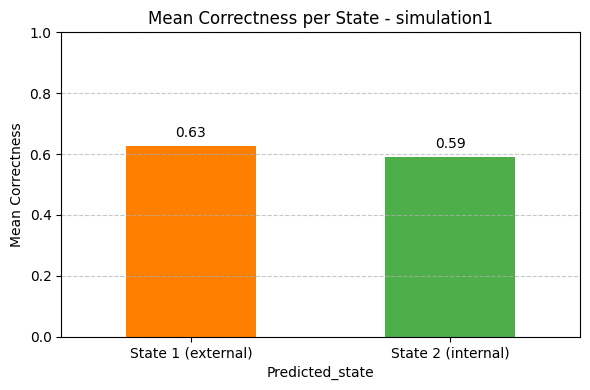

In [87]:
# === Plot the final mean correctness per state ===
mean_correctness = final_df.groupby('Predicted_state')['correct'].mean()

plt.figure(figsize=(6, 4))
mean_correctness.plot(kind='bar', color=['#ff7f00', '#4daf4a'])
plt.xticks(ticks=[0, 1], labels=['State 1 (external)', 'State 2 (internal)'], rotation=0)
plt.ylabel('Mean Correctness')
plt.title(f'Mean Correctness per State{test_type_title}')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, value in enumerate(mean_correctness):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
if save_data:
    plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/correctness_per_state.png', bbox_inches='tight')
plt.show()

In [88]:
# === For simulations, evaluate the correct classification ===
if test_type.startswith('simulation'):
    matching_rows = final_df[final_df['state'] == final_df['Predicted_state']]
    print(len(matching_rows), " trials out of ", len(final_df), " were correctly classified.")

24169  trials out of  50000  were correctly classified.


## Comparison of States

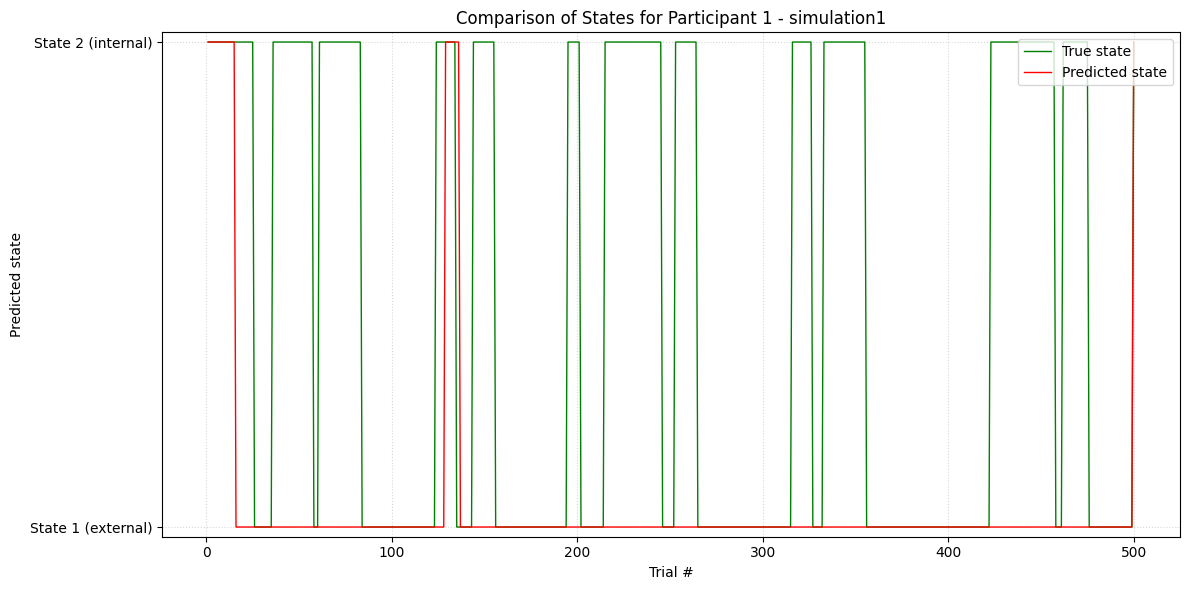

In [89]:
# === For simulations, compare the predicted state to the true state ===
if test_type.startswith('simulation'):
    plt.figure(figsize=(12, 6))

    n_initial = x_block[0]
    n_final = x_block[-1]+1

    plt.plot(x_block, final_df['state'][n_initial:n_final]-1, label='True state', color='green', linewidth=1)
    plt.plot(x_block, final_df['Predicted_state'][n_initial:n_final]-1, label='Predicted state', color='red', linewidth=1)

    plt.ylim(-0.02, 1.02)
    plt.yticks([0, 1], ['State 1 (external)', 'State 2 (internal)'])
    plt.xlabel('Trial #')
    plt.ylabel('Predicted state')
    plt.title(f'Comparison of States for Participant {sess_id+1}{test_type_title}')

    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    if save_data:
        plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/comparison_state.png', bbox_inches='tight')

    plt.show()



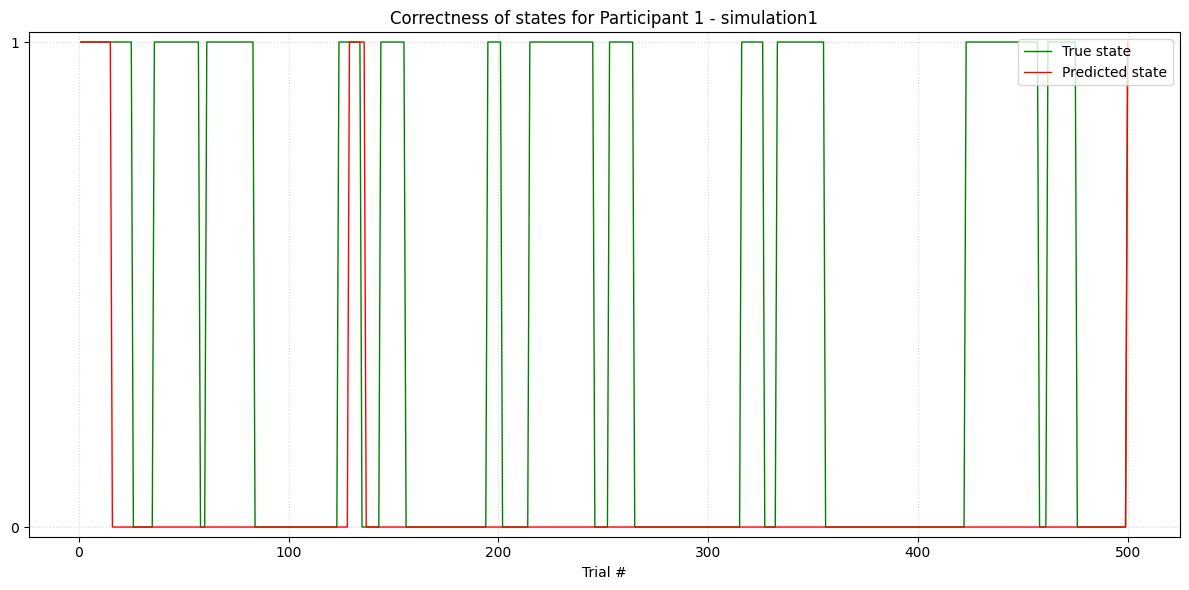

In [90]:
# === Same but easier to visualize ===
if test_type.startswith('simulation'):
    plt.figure(figsize=(12, 6))

    n_initial = x_block[0]
    n_final = x_block[-1]+1

    plt.plot(x_block, final_df['state'][n_initial:n_final]-1, label='True state', color='green', linewidth=1)
    plt.plot(x_block, final_df['Predicted_state'][n_initial:n_final]-1, label='Predicted state', color='red', linewidth=1)

    plt.ylim(-0.02, 1.02)
    plt.yticks([0, 1], ['0', '1'])
    plt.xlabel('Trial #')
    plt.ylabel('')
    plt.title(f'Correctness of states for Participant {sess_id+1}{test_type_title}')

    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    if save_data:
        plt.savefig(root_dir + f'/plots/plots_visual_perception/{test_type}/correctness_state.png', bbox_inches='tight')

    plt.show()

## What is the shape of the intervals?

In [91]:
# === For simulations, calculate the mean number of trials per interval during each state ===
if test_type.startswith('simulation'):
    state_series = final_df['state']

    transitions = state_series != state_series.shift()
    group_ids = transitions.cumsum()

    intervals = state_series.groupby(group_ids).agg(['first', 'size'])

    mean_1 = intervals[intervals['first'] == 1]['size'].mean()
    mean_2 = intervals[intervals['first'] == 2]['size'].mean()

    print(f"Mean number of trials per interval during external state (1): {mean_1:.2f} trials")
    print(f"Mean number of trials per interval during internal state (2): {mean_2:.2f} trials")

Mean number of trials per interval during external state (1): 19.51 trials
Mean number of trials per interval during internal state (2): 20.38 trials


In [92]:
# === For simulations, calculate the mean number of trials per interval per ID during each state ===
if test_type.startswith('simulation'):
    df = pd.read_csv(root_dir + f'/HMM/HMM_visual_perception/{test_type}/Full_HMM_{test_type}.csv')
    def compute_mean_intervals(group):
        
        state_series = group['state'].reset_index(drop=True)

        transitions = state_series != state_series.shift()
        group_ids = transitions.cumsum()

        intervals = state_series.groupby(group_ids).agg(['first', 'size'])

        mean_1 = intervals[intervals['first'] == 1]['size'].mean()
        mean_2 = intervals[intervals['first'] == 2]['size'].mean()
        
        return pd.Series({'External_state_(1)': mean_1, 'Internal_state_(2)': mean_2})

    intervals_per_id = df.groupby('ID').apply(compute_mean_intervals).reset_index()

    print(f"Mean number of trials per interval per ID during each state:")
    intervals_per_id.mean()

Mean number of trials per interval per ID during each state:


/var/folders/hc/f0q04dfj06d1b1f0nks6jk_00000gn/T/ipykernel_46939/3323913957.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  intervals_per_id = df.groupby('ID').apply(compute_mean_intervals).reset_index()


In [93]:
# === For simulations, calculate the mean number of intervals per ID during each state ===
if test_type.startswith('simulation'):
    def count_state_intervals(group):
        state_series = group['state'].reset_index(drop=True)
        
        transitions = state_series != state_series.shift()
        interval_ids = transitions.cumsum()
        interval_values = state_series.groupby(interval_ids).first()
        
        num_1 = (interval_values == 1).sum()
        num_2 = (interval_values == 2).sum()
        
        return pd.Series({'intervals_state_external_(1)': num_1, 'intervals_state_internal_(2)': num_2})

    interval_counts = df.groupby('ID').apply(count_state_intervals).reset_index()

    print(f"Mean number of intervals per ID during each state: {mean_1:.2f} intervals")
    interval_counts.mean()

Mean number of intervals per ID during each state: 19.51 intervals


/var/folders/hc/f0q04dfj06d1b1f0nks6jk_00000gn/T/ipykernel_46939/2280823023.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interval_counts = df.groupby('ID').apply(count_state_intervals).reset_index()
